In [2]:
from imutils.perspective import four_point_transform
from imutils import contours
import imutils
import cv2
import PIL
# from PIL import Image as im
from PIL import ImageEnhance, Image

import numpy as np
import matplotlib.pyplot as plt
FONT = cv2.FONT_HERSHEY_SIMPLEX
CYAN = (255, 255, 0)
# define the dictionary of digit segments so we can identify
# each digit on the thermostat
DIGITSDICT = {
    (1, 1, 0, 1, 1, 0, 0): 0,
    (1, 1, 1, 0, 1, 1, 1): 0,
    (1, 1, 0, 1, 1, 1, 0): 0,
    (0, 0, 1, 0, 0, 1, 0): 1,
    (1, 0, 1, 1, 1, 1, 0): 2,
    (1, 0, 1, 1, 0, 1, 1): 3,
    (0, 1, 1, 1, 0, 1, 0): 4,
    (1, 1, 0, 1, 0, 1, 1): 5,
    (1, 1, 0, 1, 1, 1, 1): 6,
    (1, 0, 1, 0, 0, 1, 0): 7,
    (1, 1, 1, 1, 1, 1, 1): 8,
    (1, 1, 1, 1, 0, 1, 1): 9,
    (1, 1, 1, 1, 1, 1, 0): 0,
    (0, 1, 1, 0, 0, 0, 0): 1,
    (1, 1, 0, 1, 1, 0, 1): 2,
    (1, 1, 1, 1, 0, 0, 1): 3,
    (0, 1, 1, 0, 0, 1, 1): 4,
    (1, 0, 1, 1, 0, 1, 1): 5,
    (1, 0, 1, 1, 1, 1, 1): 6,
    (1, 1, 1, 0, 0, 1, 0): 7,
    (1, 1, 1, 1, 1, 1, 1): 8,
    (1, 1, 1, 1, 0, 1, 1): 9
}

image = cv2.imread("C:/Users/User/Downloads/w1.jpeg")
# pre-process the image by resizing it, converting it to
# graycale, blurring it, and computing an edge map
image = imutils.resize(image, height=500)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
# edged = cv2.Canny(blurred, 50, 200, 255)
edged = cv2.Canny(blurred, 50, 200, 255)

data233 = Image.fromarray(image)
im = data233

# Setting the points for cropped image
# left = 395
# top = 150
# right = 610
# bottom = 300
left = 395
top = 192
right = 595
bottom = 280

# Cropped image of above dimension
# (It will not change original image)
im1 = im.crop((left, top, right, bottom))
im_data = np.asarray(im1)
roi_color = im_data
# roi_color = cv2.imread("inter/download.png")
# roi_color = cv2.imread("inter/ocbc-roi.png")
# roi_color = cv2.imread("inter/1.png")
# roi_color = cv2.imread("inter/download.png")
# img = Image.open("inter/1.png")
# img.show()
# filter = ImageEnhance.Brightness(img)
#
# im1 = img.filter(1.2)

# create a sharpening kernel
sharpen_filter = np.array([[-1, -1, -1],
                           [-1, 9, -1],
                           [-1, -1, -1]])
# applying kernels to the input image to get the sharpened image
roi_color = cv2.filter2D(roi_color, -1, sharpen_filter)
#cv2.imshow('Required image', roi_color)
roi = cv2.cvtColor(roi_color, cv2.COLOR_BGR2GRAY)
RATIO = roi.shape[0] * 0.1
roi = cv2.bilateralFilter(roi, 5, 30, 60)

trimmed = roi[int(RATIO):, int(RATIO): roi.shape[1] - int(RATIO)]
roi_color = roi_color[int(RATIO):, int(RATIO): roi.shape[1] - int(RATIO)]

edged = cv2.adaptiveThreshold(
    trimmed, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 5, 5
)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 5))
dilated = cv2.dilate(edged, kernel, iterations=1)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
dilated = cv2.dilate(dilated, kernel, iterations=1)


kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 1), )
eroded = cv2.erode(dilated, kernel, iterations=1)


h = roi.shape[0]
ratio = int(h * 0.07)
eroded[-ratio:, ] = 0
eroded[:, :ratio] = 0



cnts, _ = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
digits_cnts = []

canvas = trimmed.copy()
cv2.drawContours(canvas, cnts, -1, (255, 255, 255), 1)


canvas = trimmed.copy()
for cnt in cnts:
    (x, y, w, h) = cv2.boundingRect(cnt)
    if h > 20:
        digits_cnts += [cnt]
        cv2.rectangle(canvas, (x, y), (x + w, y + h), (0, 0, 0), 1)
        cv2.drawContours(canvas, cnt, 0, (255, 255, 255), 1)


print(f"No. of Digit Contours: {len(digits_cnts)}")


sorted_digits = sorted(digits_cnts, key=lambda cnt: cv2.boundingRect(cnt)[0])

canvas = trimmed.copy()

for i, cnt in enumerate(sorted_digits):
    (x, y, w, h) = cv2.boundingRect(cnt)
    cv2.rectangle(canvas, (x, y), (x + w, y + h), (0, 0, 0), 1)
    cv2.putText(canvas, str(i), (x, y - 3), FONT, 0.3, (0, 0, 0), 1)

digits = []
canvas = roi_color.copy()
for cnt in sorted_digits:
    (x, y, w, h) = cv2.boundingRect(cnt)
    roi = eroded[y: y + h, x: x + w]
    print(f"W:{w}, H:{h}")
    # convenience units
    qW, qH = int(w * 0.25), int(h * 0.15)
    fractionH, halfH, fractionW = int(h * 0.05), int(h * 0.5), int(w * 0.25)

    # seven segments in the order of wikipedia's illustration
    sevensegs = [
        ((0, 0), (w, qH)),  # a (top bar)
        ((w - qW, 0), (w, halfH)),  # b (upper right)
        ((w - qW, halfH), (w, h)),  # c (lower right)
        ((0, h - qH), (w, h)),  # d (lower bar)
        ((0, halfH), (qW, h)),  # e (lower left)
        ((0, 0), (qW, halfH)),  # f (upper left)
        # ((0, halfH - fractionH), (w, halfH + fractionH)) # center
        (
            (0 + fractionW, halfH - fractionH),
            (w - fractionW, halfH + fractionH),
        ),  # center
    ]

    # initialize to off
    on = [0] * 7

    for (i, ((p1x, p1y), (p2x, p2y))) in enumerate(sevensegs):
        region = roi[p1y:p2y, p1x:p2x]
        print(
            f"{i}: Sum of 1: {np.sum(region == 255)}, Sum of 0: {np.sum(region == 0)}, Shape: {region.shape}, Size: {region.size}"
        )
        if np.sum(region == 255) > region.size * 0.5:
            on[i] = 1
        print(f"State of ON: {on}")

    digit = DIGITSDICT[tuple(on)]
    print(f"Digit is: {digit}")
    digits += [digit]
    cv2.rectangle(canvas, (x, y), (x + w, y + h), CYAN, 1)
    cv2.putText(canvas, str(digit), (x - 5, y + 6), FONT, 0.3, (0, 0, 0), 1)
    cv2.imshow("Digit", canvas)
    cv2.waitKey(0)

cv2.destroyAllWindows()

print(f"Digits on the token are: {digits}")
print(u"{}{}.{}{} \u00b0kg".format(*digits))


No. of Digit Contours: 4
W:37, H:70
0: Sum of 1: 308, Sum of 0: 62, Shape: (10, 37), Size: 370
State of ON: [1, 0, 0, 0, 0, 0, 0]
1: Sum of 1: 218, Sum of 0: 97, Shape: (35, 9), Size: 315
State of ON: [1, 1, 0, 0, 0, 0, 0]
2: Sum of 1: 7, Sum of 0: 308, Shape: (35, 9), Size: 315
State of ON: [1, 1, 0, 0, 0, 0, 0]
3: Sum of 1: 260, Sum of 0: 110, Shape: (10, 37), Size: 370
State of ON: [1, 1, 0, 1, 0, 0, 0]
4: Sum of 1: 221, Sum of 0: 94, Shape: (35, 9), Size: 315
State of ON: [1, 1, 0, 1, 1, 0, 0]
5: Sum of 1: 113, Sum of 0: 202, Shape: (35, 9), Size: 315
State of ON: [1, 1, 0, 1, 1, 0, 0]
6: Sum of 1: 100, Sum of 0: 14, Shape: (6, 19), Size: 114
State of ON: [1, 1, 0, 1, 1, 0, 1]
Digit is: 2
W:40, H:68
0: Sum of 1: 155, Sum of 0: 245, Shape: (10, 40), Size: 400
State of ON: [0, 0, 0, 0, 0, 0, 0]
1: Sum of 1: 257, Sum of 0: 83, Shape: (34, 10), Size: 340
State of ON: [0, 1, 0, 0, 0, 0, 0]
2: Sum of 1: 214, Sum of 0: 126, Shape: (34, 10), Size: 340
State of ON: [0, 1, 1, 0, 0, 0, 0]
3: 

In [ ]:
from imutils.perspective import four_point_transform
from imutils import contours
import imutils
import cv2
import PIL
# from PIL import Image as im
from PIL import ImageEnhance, Image

import numpy as np
import matplotlib.pyplot as plt
FONT = cv2.FONT_HERSHEY_SIMPLEX
CYAN = (255, 255, 0)
# define the dictionary of digit segments so we can identify
# each digit on the thermostat
DIGITSDICT = {
    (1, 1, 0, 1, 1, 0, 0): 0,
    (1, 1, 1, 0, 1, 1, 1): 0,
    (1, 1, 0, 1, 1, 1, 0): 0,
    (0, 0, 1, 0, 0, 1, 0): 1,
    (1, 0, 1, 1, 1, 1, 0): 2,
    (1, 0, 1, 1, 0, 1, 1): 3,
    (0, 1, 1, 1, 0, 1, 0): 4,
    (1, 1, 0, 1, 0, 1, 1): 5,
    (1, 1, 0, 1, 1, 1, 1): 6,
    (1, 0, 1, 0, 0, 1, 0): 7,
    (1, 1, 1, 1, 1, 1, 1): 8,
    (1, 1, 1, 1, 0, 1, 1): 9,
    (1, 1, 1, 1, 1, 1, 0): 0,
    (0, 1, 1, 0, 0, 0, 0): 1,
    (1, 1, 0, 1, 1, 0, 1): 2,
    (1, 1, 1, 1, 0, 0, 1): 3,
    (0, 1, 1, 0, 0, 1, 1): 4,
    (1, 0, 1, 1, 0, 1, 1): 5,
    (1, 0, 1, 1, 1, 1, 1): 6,
    (1, 1, 1, 0, 0, 1, 0): 7,
    (1, 1, 1, 1, 1, 1, 1): 8,
    (1, 1, 1, 1, 0, 1, 1): 9
}

In [5]:
image = cv2.imread("C:/Users/User/Downloads/w1.jpeg")
# pre-process the image by resizing it, converting it to
# graycale, blurring it, and computing an edge map
image = imutils.resize(image, height=500)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
# edged = cv2.Canny(blurred, 50, 200, 255)
edged = cv2.Canny(blurred, 50, 200, 255)

In [9]:
data233 = Image.fromarray(image)
# data233 = Image.fromarray(gray)
im = data233

In [10]:

# Setting the points for cropped image
# left = 395
# top = 150
# right = 610
# bottom = 300
left = 395
top = 192
right = 595
bottom = 280

# Cropped image of above dimension
# (It will not change original image)
im1 = im.crop((left, top, right, bottom))
im_data = np.asarray(im1)
roi_color = im_data
# roi_color = cv2.imread("inter/download.png")
# roi_color = cv2.imread("inter/ocbc-roi.png")
# roi_color = cv2.imread("inter/1.png")
# roi_color = cv2.imread("inter/download.png")
# img = Image.open("inter/1.png")
# img.show()
# filter = ImageEnhance.Brightness(img)
#
# im1 = img.filter(1.2)

In [11]:

# create a sharpening kernel
sharpen_filter = np.array([[-1, -1, -1],
                           [-1, 9, -1],
                           [-1, -1, -1]])
# applying kernels to the input image to get the sharpened image
roi_color = cv2.filter2D(roi_color, -1, sharpen_filter)
#cv2.imshow('Required image', roi_color)
roi = cv2.cvtColor(roi_color, cv2.COLOR_BGR2GRAY)
RATIO = roi.shape[0] * 0.1
roi = cv2.bilateralFilter(roi, 5, 30, 60)

In [12]:


trimmed = roi[int(RATIO):, int(RATIO): roi.shape[1] - int(RATIO)]
roi_color = roi_color[int(RATIO):, int(RATIO): roi.shape[1] - int(RATIO)]

edged = cv2.adaptiveThreshold(
    trimmed, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 5, 5
)


In [13]:


kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 5))
dilated = cv2.dilate(edged, kernel, iterations=1)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
dilated = cv2.dilate(dilated, kernel, iterations=1)


kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 1), )
eroded = cv2.erode(dilated, kernel, iterations=1)



In [14]:

h = roi.shape[0]
ratio = int(h * 0.07)
eroded[-ratio:, ] = 0
eroded[:, :ratio] = 0



cnts, _ = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
digits_cnts = []

canvas = trimmed.copy()
cv2.drawContours(canvas, cnts, -1, (255, 255, 255), 1)


canvas = trimmed.copy()

In [15]:

for cnt in cnts:
    (x, y, w, h) = cv2.boundingRect(cnt)
    if h > 20:
        digits_cnts += [cnt]
        cv2.rectangle(canvas, (x, y), (x + w, y + h), (0, 0, 0), 1)
        cv2.drawContours(canvas, cnt, 0, (255, 255, 255), 1)


print(f"No. of Digit Contours: {len(digits_cnts)}")


sorted_digits = sorted(digits_cnts, key=lambda cnt: cv2.boundingRect(cnt)[0])

canvas = trimmed.copy()


No. of Digit Contours: 4


In [16]:

for i, cnt in enumerate(sorted_digits):
    (x, y, w, h) = cv2.boundingRect(cnt)
    cv2.rectangle(canvas, (x, y), (x + w, y + h), (0, 0, 0), 1)
    cv2.putText(canvas, str(i), (x, y - 3), FONT, 0.3, (0, 0, 0), 1)

digits = []
canvas = roi_color.copy()

In [17]:
for cnt in sorted_digits:
    (x, y, w, h) = cv2.boundingRect(cnt)
    roi = eroded[y: y + h, x: x + w]
    print(f"W:{w}, H:{h}")
    # convenience units
    qW, qH = int(w * 0.25), int(h * 0.15)
    fractionH, halfH, fractionW = int(h * 0.05), int(h * 0.5), int(w * 0.25)

    # seven segments in the order of wikipedia's illustration
    sevensegs = [
        ((0, 0), (w, qH)),  # a (top bar)
        ((w - qW, 0), (w, halfH)),  # b (upper right)
        ((w - qW, halfH), (w, h)),  # c (lower right)
        ((0, h - qH), (w, h)),  # d (lower bar)
        ((0, halfH), (qW, h)),  # e (lower left)
        ((0, 0), (qW, halfH)),  # f (upper left)
        # ((0, halfH - fractionH), (w, halfH + fractionH)) # center
        (
            (0 + fractionW, halfH - fractionH),
            (w - fractionW, halfH + fractionH),
        ),  # center
    ]

    # initialize to off
    on = [0] * 7

    for (i, ((p1x, p1y), (p2x, p2y))) in enumerate(sevensegs):
        region = roi[p1y:p2y, p1x:p2x]
        print(
            f"{i}: Sum of 1: {np.sum(region == 255)}, Sum of 0: {np.sum(region == 0)}, Shape: {region.shape}, Size: {region.size}"
        )
        if np.sum(region == 255) > region.size * 0.5:
            on[i] = 1
        print(f"State of ON: {on}")

    digit = DIGITSDICT[tuple(on)]
    print(f"Digit is: {digit}")
    digits += [digit]
    cv2.rectangle(canvas, (x, y), (x + w, y + h), CYAN, 1)
    cv2.putText(canvas, str(digit), (x - 5, y + 6), FONT, 0.3, (0, 0, 0), 1)
    cv2.imshow("Digit", canvas)
    cv2.waitKey(0)

print(f"Digits on the token are: {digits}")
print(u"{}{}.{}{} \u00b0kg".format(*digits))

W:37, H:70
0: Sum of 1: 308, Sum of 0: 62, Shape: (10, 37), Size: 370
State of ON: [1, 0, 0, 0, 0, 0, 0]
1: Sum of 1: 218, Sum of 0: 97, Shape: (35, 9), Size: 315
State of ON: [1, 1, 0, 0, 0, 0, 0]
2: Sum of 1: 7, Sum of 0: 308, Shape: (35, 9), Size: 315
State of ON: [1, 1, 0, 0, 0, 0, 0]
3: Sum of 1: 260, Sum of 0: 110, Shape: (10, 37), Size: 370
State of ON: [1, 1, 0, 1, 0, 0, 0]
4: Sum of 1: 221, Sum of 0: 94, Shape: (35, 9), Size: 315
State of ON: [1, 1, 0, 1, 1, 0, 0]
5: Sum of 1: 113, Sum of 0: 202, Shape: (35, 9), Size: 315
State of ON: [1, 1, 0, 1, 1, 0, 0]
6: Sum of 1: 100, Sum of 0: 14, Shape: (6, 19), Size: 114
State of ON: [1, 1, 0, 1, 1, 0, 1]
Digit is: 2
W:40, H:68
0: Sum of 1: 155, Sum of 0: 245, Shape: (10, 40), Size: 400
State of ON: [0, 0, 0, 0, 0, 0, 0]
1: Sum of 1: 257, Sum of 0: 83, Shape: (34, 10), Size: 340
State of ON: [0, 1, 0, 0, 0, 0, 0]
2: Sum of 1: 214, Sum of 0: 126, Shape: (34, 10), Size: 340
State of ON: [0, 1, 1, 0, 0, 0, 0]
3: Sum of 1: 104, Sum of 0: 

In [2]:
!pip install imutils


  Using cached imutils-0.5.4-py3-none-any.whl


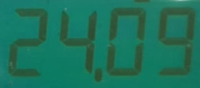

In [18]:
im1